In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Load and default preprocessing

In [2]:
# load data
with open('../witt_preprocessing/pickles/dangjin_merged.pkl','rb') as f:
    dangjin_data = pickle.load(f)
with open('../witt_preprocessing/pickles/ulsan_merged.pkl','rb') as f:
    ulsan_data = pickle.load(f)


# preprocess data for modeling

# time as index
dangjin_data.set_index('time', inplace=True)
ulsan_data.set_index('time', inplace=True)

# dangjin - sum target values
dangjin_data['dangjin_sum'] = dangjin_data['dangjin'] + dangjin_data['dangjin_floating'] + dangjin_data['dangjin_warehouse']
dangjin_data.drop(columns=['dangjin','dangjin_floating','dangjin_warehouse'], inplace=True)

# delete rows where target == 0
dangjin_data = dangjin_data.loc[dangjin_data['dangjin_sum'] != 0]
ulsan_data = ulsan_data.loc[ulsan_data['ulsan'] != 0]

## Validate

In [4]:
def validate(model, data, x_cols, y_cols, test_size=0.2):
    # input-target split
    x = data.loc[:,x_cols]
    y = data.loc[:,y_cols]

    # train-test split
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_size, shuffle=False)

    # fit and predict
    model.fit(train_x, train_y)
    predict = model.predict(test_x)

    return predict, test_y

In [62]:
def evaluate(predict, y):
    return abs(predict - y.iloc[:,0]).sum(axis=0)

In [6]:
x_cols_obs = ['Temperature_obs', 'Humidity_obs','Cloud_obs','Day_cos','Day_sin','Year_cos','Year_sin']
x_cols_fcst = ['Temperature_fcst','Humidity_fcst','Cloud_fcst','Day_cos','Day_sin','Year_cos','Year_sin']

y_dangjin_cols = ['dangjin_sum']
y_ulsan_cols = ['ulsan']

In [15]:
RS = 27

model = RandomForestRegressor(criterion='mae', verbose=1, n_jobs=-1, random_state=RS, n_estimators=100, min_samples_leaf=10)
dangjin_predict, dangjin_y = validate(model, dangjin_shifted, x_cols_fcst, y_dangjin_cols)

# error
evaluate(dangjin_predict, dangjin_y)

<ipython-input-13-1867bd3a1296>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
Sum of error: 394764.8304703608
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [58]:
# current best(random_state): 380975(17) / 382025(19)
# config: 
# x= ['Temperature_fcst', 'Humidity_fcst','Cloud_fcst','Day_cos','Day_sin','Year_cos','Year_sin']
# RandomForestRegressor(criterion='mae', verbose=2, n_jobs=-1, random_state=10, n_estimators=100, min_sample_leaf=10)

## Experiment 1: Ensemble different timesteps (from 0,3,6,9)
-> 단순한 shift로는 성능 저하 심함

In [50]:
timesteps = [0,1,2,3]

def ensemble_timestep(data, x_cols, y_cols):
    predicts = []

    # test set size 미리 정하기. 비율로 split할 경우 ts별 size 불일치.
    test_size = int(data.shape[0] * 0.2)

    for ts in timesteps:
        print('='*50, ts, '='*50)

        # shift data
        data_shifted = data.copy()
        data_shifted[x_cols] = data_shifted[x_cols].shift(ts)
        data_shifted.dropna(inplace=True)

        # validate
        model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, random_state=27, n_estimators=100, min_samples_leaf=10)
        predict, test_y = validate(model, data_shifted, x_cols, y_cols, test_size=test_size)
        predicts.append(predict)

    return predicts, test_y  # test_y is always same

In [51]:
ensemble_predict, test_y = ensemble_timestep(dangjin_data, x_cols_fcst, y_dangjin_cols)

================================================== 0 ==================================================
<ipython-input-4-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
================================================== 1 ==================================================
<ipython-input-4-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
================================================== 2 ==================================================
<ipython-input-4-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
============================

In [52]:
ensemble_predict_mean = np.stack(ensemble_predict, axis=0).mean(axis=0)

In [53]:
for i in range(4):
    prnt(evaluate((ensemble_predict[i], test_y))

evaluate(ensemble_predict_mean, test_y)

Sum of error: 382008.4713433706
Sum of error: 421163.1643600024
Sum of error: 492006.55496234837
Sum of error: 549890.5426903588
Sum of error: 421243.17365042504


## Ensemble 2: Hp tuning (min_samples_leaf)
> May 19:
- 4- 6- 5- 7- 3

In [71]:
# Hp tuning
msl_list = np.arange(2,11,step=1) # hp(min_samples_leaf) list
ITER = 3

# dictionary to store errors
error_by_msl = {x:[] for x in msl_list}

# loop over msl
for msl in msl_list:
        # iter
    for i in range(ITER):
        print('min_samples_leaf:',msl,'iter:',i) 
        model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, n_estimators=100, min_samples_leaf=msl)

        predict, test_y = validate(model, dangjin_data, x_cols_fcst, y_dangjin_cols)

        error_by_msl[msl].append(evaluate(predict, test_y))

error_by_msl = pd.DataFrame(error_by_msl)
error_by_msl.loc['mean',:] = error_by_msl.mean(axis=0)

min_samples_leaf: 2 iter: 0
<ipython-input-4-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
min_samples_leaf: 2 iter: 1
<ipython-input-4-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
min_samples_leaf: 2 iter: 2
<ipython-input-4-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
min_samples_leaf: 3 iter: 0
<ipython-input-4-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
min_samp

## Additional function: plot

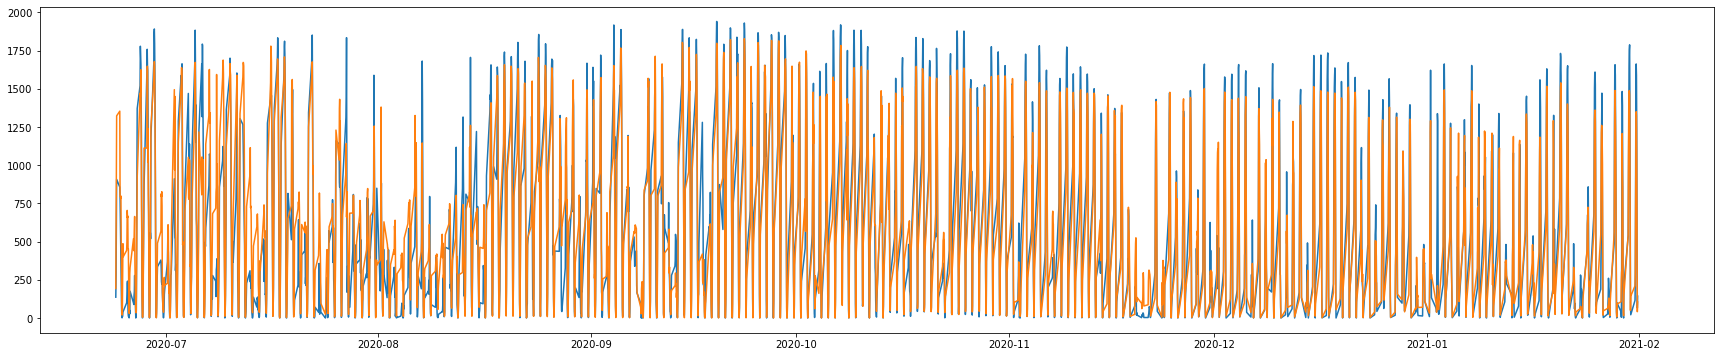

In [11]:
# plot
plt.figure(figsize=(30,6))

plt.plot(dangjin_y)

dangjin_predict_ = pd.Series(dangjin_predict, index=dangjin_y.index)
plt.plot(dangjin_predict_)